# Artificial Neural Networks and Deep Learning - Homework 2

| Overfitters del test set    | PoliMi ID |
|:----------------------------|:---------:|
|Pertino Paolo                | 10729600  |
|Sandri Alberto               | 10698469  |
|Simionato Enrico             | 10698193  |

In the second homework of the Artificial Neural Networks and Deep Learning course, a time series forecasting is proposed. The goal is to predict future samples of the input time series.

## 0. Preliminary operations

In the following section some preliminary operations in order to setup the environment correctly are performed.

### 0.1 Connect to Drive

In [ ]:
try:
    from google.colab import drive
    print("Code running on Google Colab... Conncecting to Google Drive...")
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 2
except:
    print("The code is not running on Google Colab...")

Code running on Google Colab... Conncecting to Google Drive...
Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 2


### 0.2 Download and import Libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install pandas
!pip install scipy
!pip install Cython
!pip install opencv-python
!pip install -U keras_cv
!pip install imbalanced-learn
!pip install lime

In [ ]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.7/586.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 48.5 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.4
    Uninstalling websocket-client-1.6.4:
      Successfully uninstalled websocket-client-1.6.4
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [ ]:
try:
    import comet_ml
    from comet_ml import Experiment
    from comet_ml.integration.pytorch import log_model

    comet_ml.init(project_name='ANNDL-TS FORECASTING')
except:
    print("Comet-ML is not installed on this platform. Skipping the import...")

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
import warnings
import logging
import random
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

random.seed(seed)

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
np.random.seed(seed)

from scipy.signal import detrend
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet_v2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.utils import resample
from IPython.display import Image
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from skimage.segmentation import mark_boundaries

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

path_to_models='models/'

2.14.0
Num GPUs Available: 1


In [ ]:
try:
    from lime import lime_image
except:
    print("Lime is not installed on this platform. Skipping the import...")

Lime is not installed on this platform. Skipping the import...


## 1. Dataset inspection

In this section the content of the dataset is inspected and the images are prepared for later analysis.

### 1.1 Loading the data

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

In [ ]:
def detrend_with_mask(x):
    # Create a mask for non-zero values
    mask = x != 0

    # If all values are zero, return the original array
    if np.all(~mask):
        return x

    # Detrend only non-zero values
    detrended_values = detrend(x[mask])

    # Replace the detrended values in the original array
    x[mask] = detrended_values

    return x

In [ ]:
detrended_data = np.apply_along_axis(detrend_with_mask, axis=1, arr=training_data.copy())
trends = training_data - detrended_data

detrended_data.shape

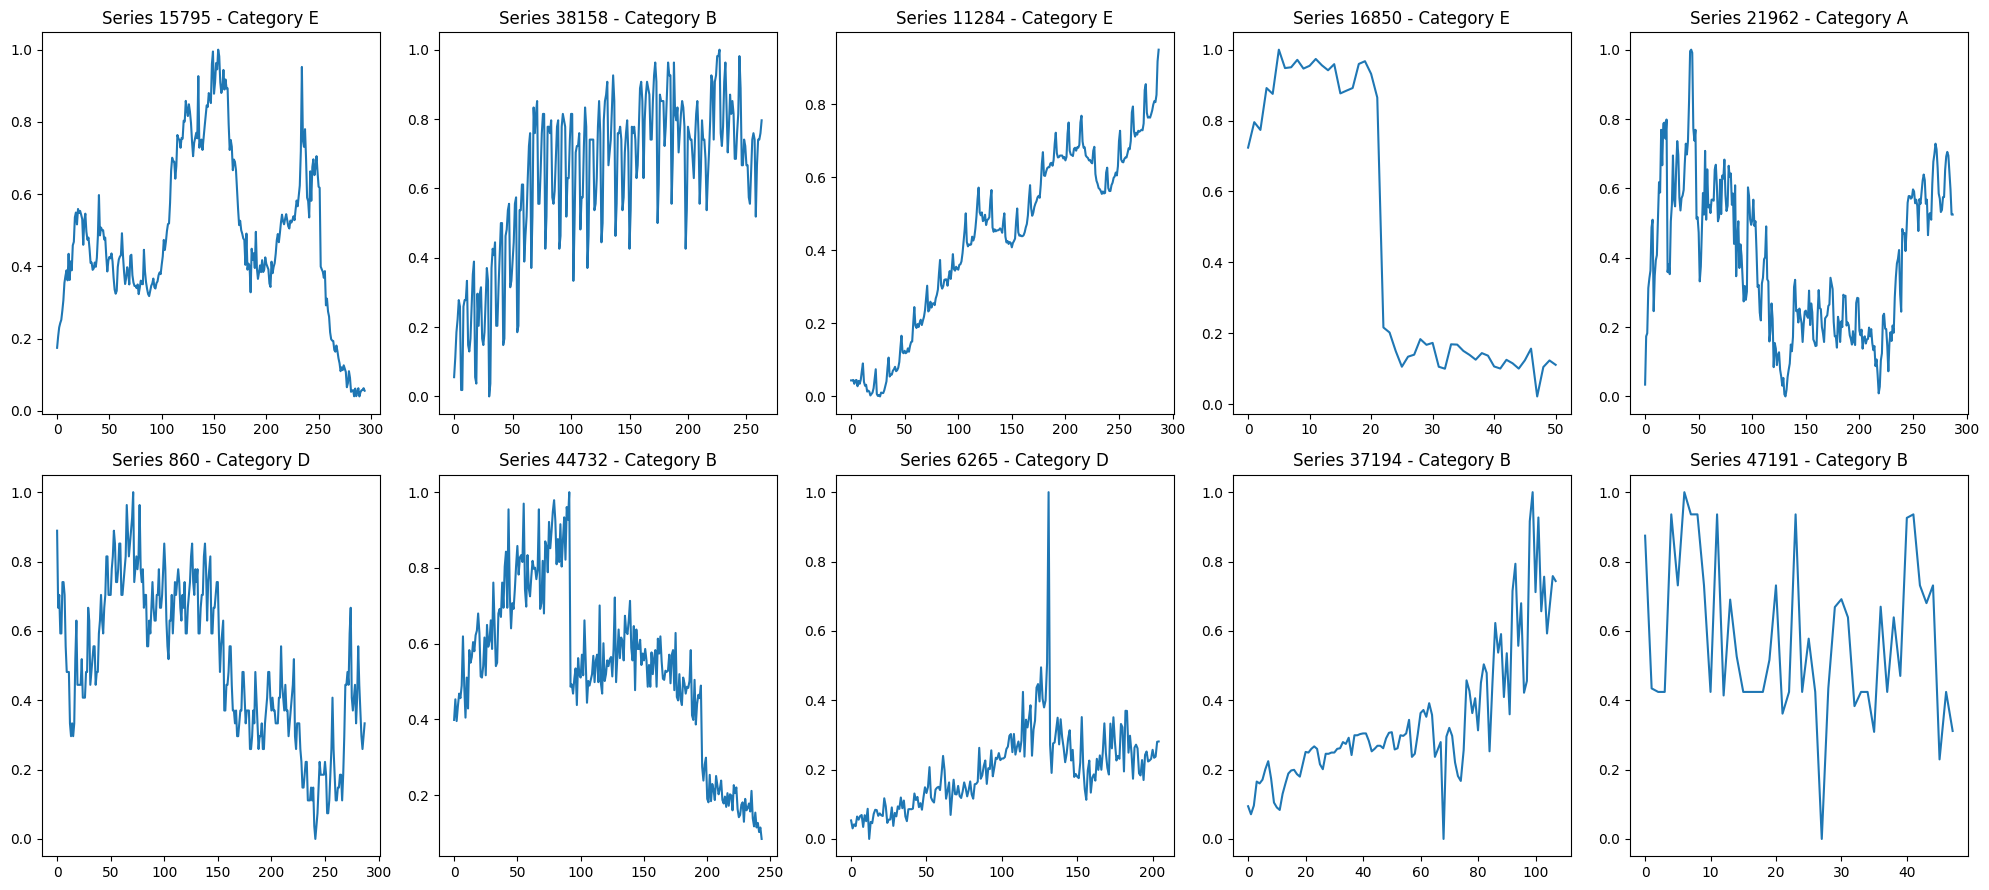

In [ ]:
num_series = 10

fig, axes = plt.subplots(2, num_series // 2, figsize=(20, 9))
for i in range(num_series):
    ax = axes[i % 2, i % num_series // 2]
    index_shown = np.random.randint(0, categories.shape[0])
    #index_shown = np.random.choice(np.where(categories == 'A')[0])
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]], label = 'original')
    ax.plot(detrended_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]], label = 'detrended')
    ax.legend()
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

### 1.2 Outliers removal

Check for missing values like NaN or infinite.

In [ ]:
has_missing_values = np.isnan(training_data).any() or np.isinf(training_data).any()

if has_missing_values:
    print("The array contains missing values.")
else:
    print("The array does not contain missing values.")

The array does not contain missing values.


Finally let's check if there are duplicates and eventually remove them.

In [ ]:
# Combine the image data and labels into a single array
combined_data = np.c_[training_data, categories]

# Convert the combined data to a Pandas DataFrame
df = pd.DataFrame(training_data)

# Search for duplicates
duplicates = df.duplicated()

print(f'There are {sum(duplicates)} duplicates')

There are 26 duplicates


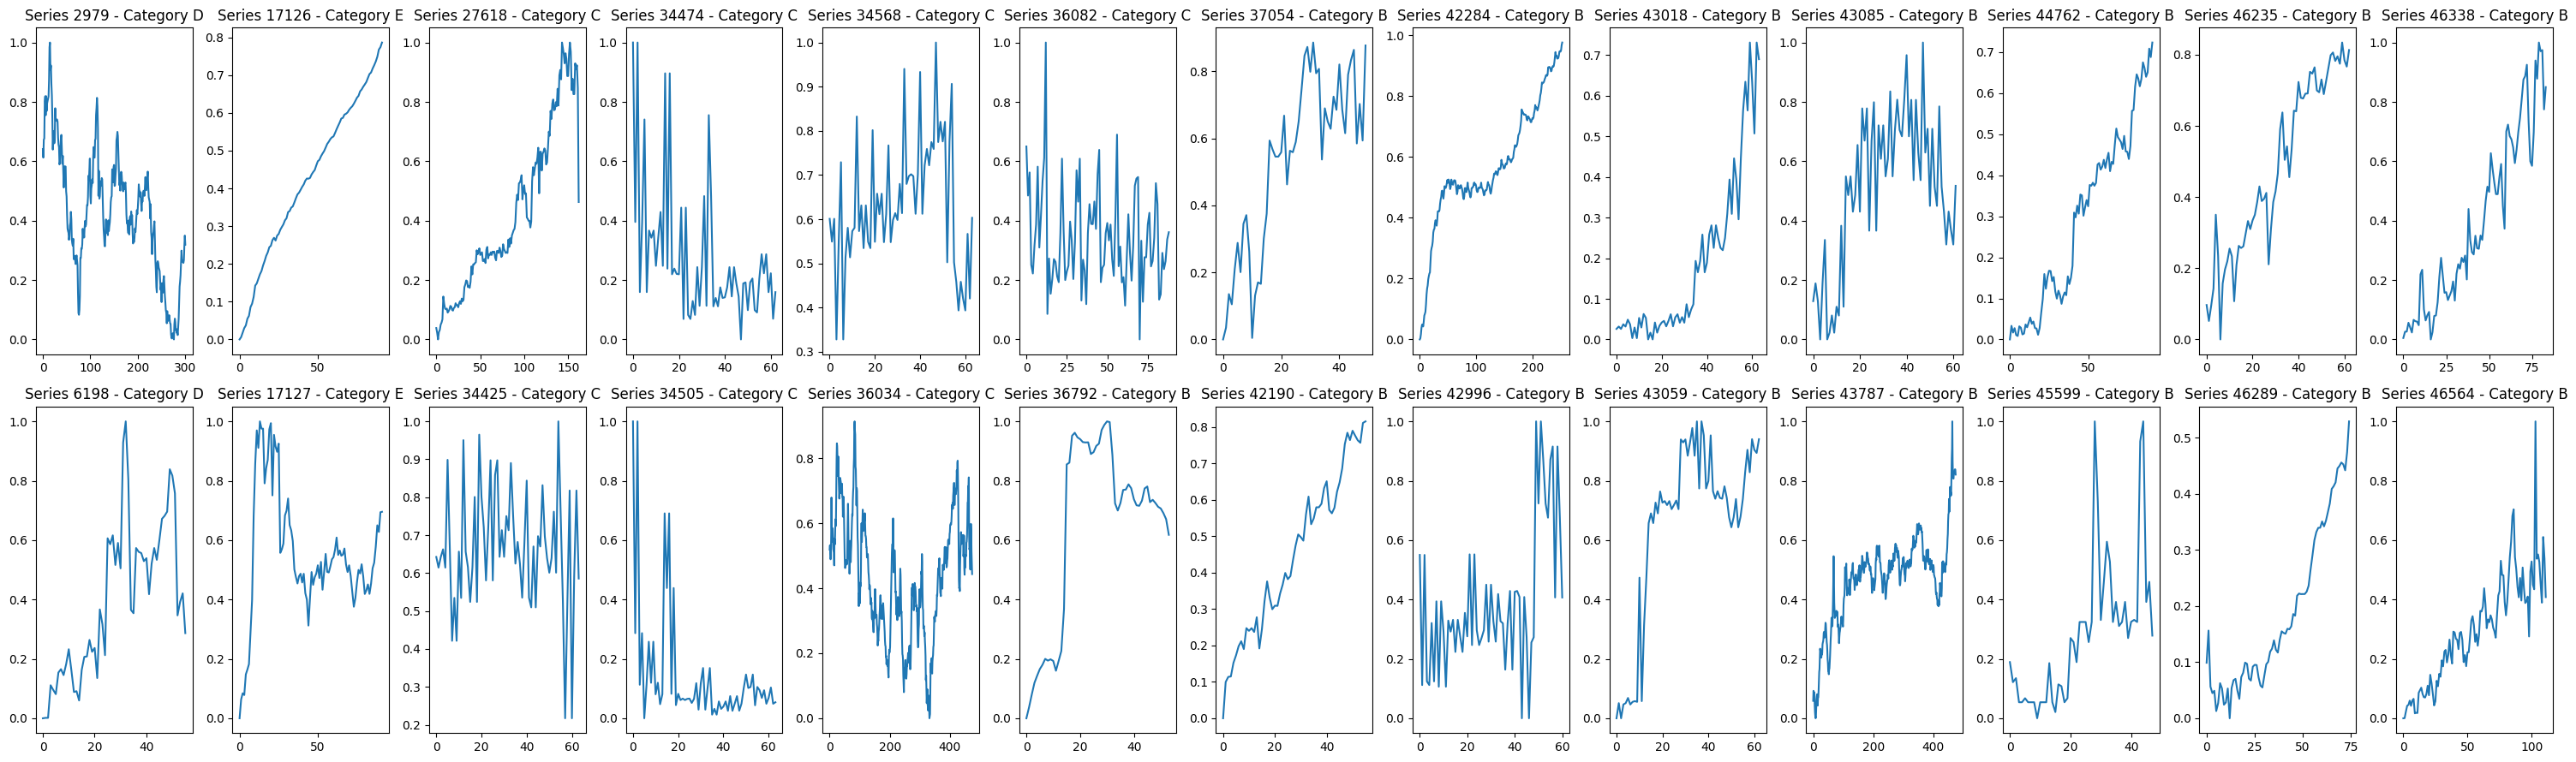

In [ ]:
# Find indexes of the duplicated time series
dup_idxs = np.where(duplicates == True)[0]
num_series = len(dup_idxs)

# Plot the duplicated time series
fig, axes = plt.subplots(2, num_series // 2, figsize=(30, 9))
for i, index_shown in enumerate(dup_idxs):
    ax = axes[i % 2, i % num_series // 2]
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]])
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

In [ ]:
print(f"Original datasets shape: categories {categories.shape}, training_data {training_data.shape}, valid_peiods {valid_periods.shape}")

# Create mask to eliminate the duplicates
duplicates = np.invert(duplicates.values)

# Eliminate the duplicates
categories = categories[duplicates]
training_data = training_data[duplicates]
valid_periods = valid_periods[duplicates]

print(f"Datasets shape after removing duplicates: categories {categories.shape}, training_data {training_data.shape}, valid_peiods {valid_periods.shape}")

Original datasets shape: categories (48000,), training_data (48000, 2776), valid_peiods (48000, 2)
Datasets shape after removing duplicates: categories (47974,), training_data (47974, 2776), valid_peiods (47974, 2)


### 1.3 Storing and loading the dataset without duplicates

In [ ]:
# Storing the dataset without duplicates
np.save('data/categories', categories, allow_pickle=True)
np.save('data/training_data', training_data, allow_pickle=True)
np.save('data/valid_periods', valid_periods, allow_pickle=True)

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True).astype(np.float32)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((47974,), (47974, 2776), (47974, 2))

### 1.4 Plots and statistics

In [ ]:
print(f'Min lenght of a series: {np.min(valid_periods[:,1]-valid_periods[:,0])}')
print(f'Max lenght of a series: {np.max(valid_periods[:,1]-valid_periods[:,0])}')

Min lenght of a series: 24
Max lenght of a series: 2776


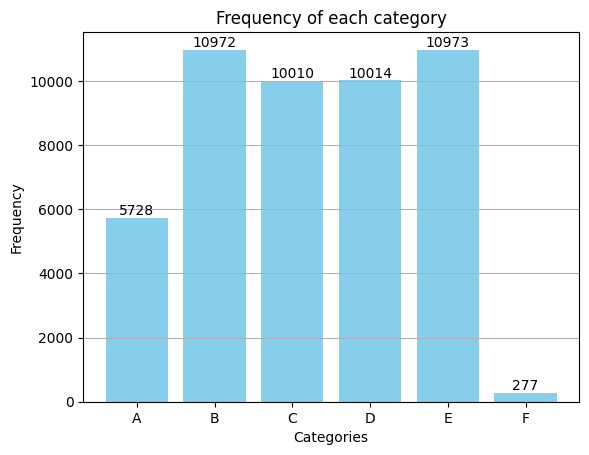

In [ ]:
# Count the frequency of each category
unique_categories, counts = np.unique(categories, return_counts=True)

# Create a bar plot
plt.bar(unique_categories, counts, color='skyblue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency of each category')
plt.grid(axis='y')

# Add counts on top of the bars
for i, count in enumerate(counts):
  plt.text(unique_categories[i], count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


Classes **B**, **C**, **D**, **E** are equally balanced with 10000 samples each. Class **A** has half samples, instead class **F** is much underrepresented.

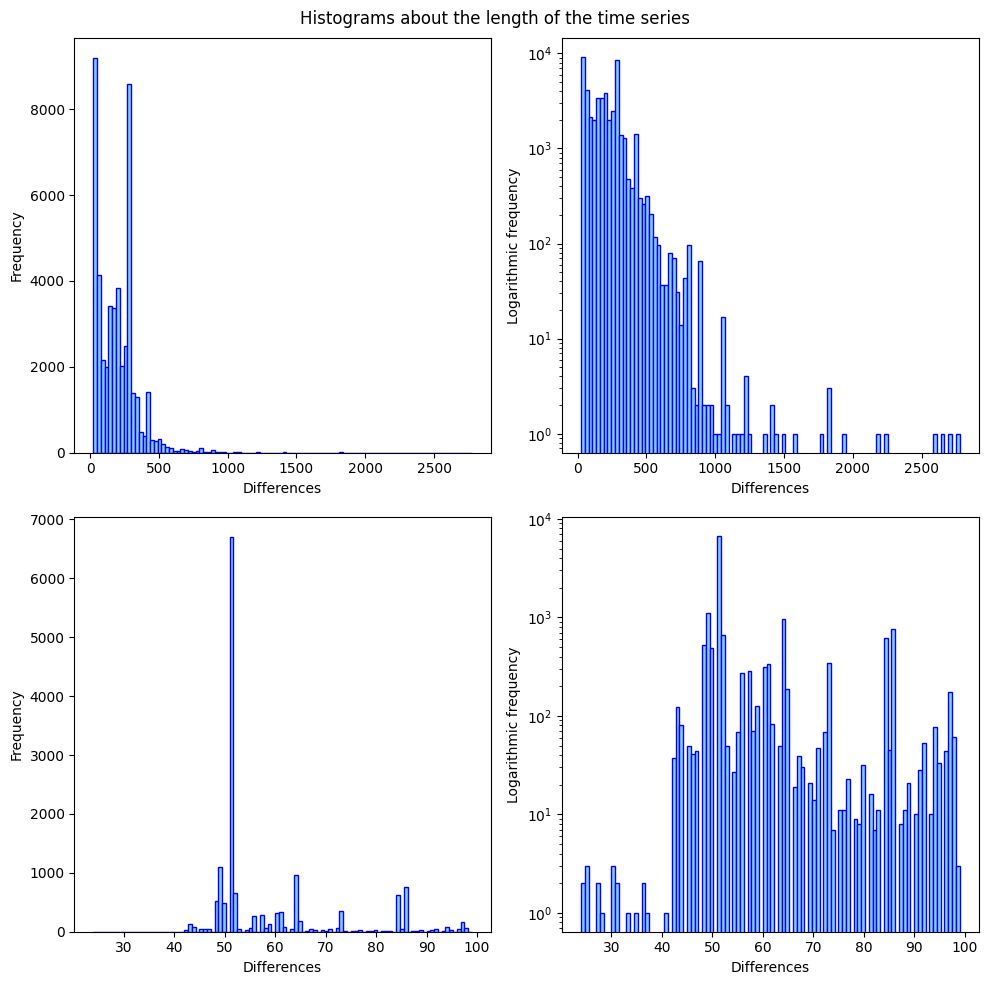

In [ ]:
# Calculating differences between ending point and starting point of the time
# series contained in the dataset
differences = valid_periods[:, 1] - valid_periods[:, 0]
# Cropping a part of the differences to focus on some interval
differences_cropped = differences[differences < 100]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Histograms about the length of the time series')
axes = axes.flatten()

# Creating a histogram plot
axes[0].hist(differences, bins=100, color='skyblue', edgecolor='blue')

# Adding labels
axes[0].set_xlabel('Differences')
axes[0].set_ylabel('Frequency')

# Creating a histogram plot
axes[1].hist(differences, bins=100, color='skyblue', edgecolor='blue', log=True)

# Adding labels
axes[1].set_xlabel('Differences')
axes[1].set_ylabel('Logarithmic frequency')

# Creating a histogram plot
axes[2].hist(differences_cropped, bins=100, color='skyblue', edgecolor='blue')

# Adding labels
axes[2].set_xlabel('Differences')
axes[2].set_ylabel('Frequency')

# Creating a histogram plot
axes[3].hist(differences_cropped, bins=100, color='skyblue', edgecolor='blue', log=True)

# Adding labels
axes[3].set_xlabel('Differences')
axes[3].set_ylabel('Logarithmic frequency')

# Showing the plot
plt.tight_layout()
plt.show()

There are a lot of time series with length between 0 and 1000. A small number of samples with very wide interavals are present in the dataset. Inspecting the dataset is possible to see that a small number of samples have a length smaller than 40. This is an important information that could be used to eliminate samples that are too small to be used to train the model.

### 1.5 Pre-processing

In [ ]:
def create_dataset(original_data: np.ndarray,
                   intervals: np.ndarray,
                   window: int,
                   stride: int,
                   telescope: int) -> np.ndarray:
  '''
  Create a dataset from the original data based on specified window, stride, and telescope.

  Parameters:
    original_data (numpy.ndarray): Original data.
    intervals (numpy.ndarray): Intervals of each sample in the original data.
    window (int): Size of the window.
    stride (int): Stride for creating new samples.
    telescope (int): Size of the telescope.

  Returns:
    numpy.ndarray: New samples created from the original data.
      First element: Features (input data).
      Second element: Corresponding targets for the new samples.
  '''

  new_samples = []
  new_targets = []

  # Iterating through each sample in the original data
  for sample_idx, sample in enumerate(tqdm(original_data, desc="Creating Dataset")):
    # Extracting the relevant time series based on the provided intervals
    series = sample[int(intervals[sample_idx,0]):int(intervals[sample_idx,1])]
    length_sample = series.shape[0]

    # Calculating the number of samples that can be extracted from the current
    # sample
    if length_sample >= window + telescope:
      n_new_samples = ((length_sample - window - telescope) // stride)
    elif length_sample > telescope:
      n_new_samples = 1
    else:
      n_new_samples = 0

    if n_new_samples > 0:
      # Initializing arrays for features and targets
      features = np.zeros((n_new_samples, window))
      targets = np.zeros((n_new_samples, telescope))

      # Creating the new dataset for the considered sample
      for i in range(n_new_samples):
        start = length_sample - i * stride - window - telescope
        end = start + window

        if start >= 0:
          features[i, :] = series[start:end]
          targets[i, :] = series[end : end + telescope]
        else:
          # Padding for cases where the start index is negative
          features[i, :] = np.pad(series[0:end], ((window - end, 0)), 'constant', constant_values=0)
          targets[i, :] = series[end : end + telescope]

      # Appending the features and targets to the new_samples and new_targets lists
      for element in features:
        new_samples.append(element)
      for element in targets:
        new_targets.append(element)

  # Converting the lists to numpy arrays before returning
  return np.array(new_samples), np.array(new_targets)


### 1.6. Experiment Tracking

Since one of the main problems in the previous challenge was tracking all our experiments, including hyperparameters and metrics, we decided to lavarage on an automatic tool, i.e. `comet-ml`, to do so. We aslo tried `TensorBoard` but Comet turned out to fit better our needs.

In the following section, some utility functions are created to handle this new feature.

In [ ]:
def create_experiment(experiment_name = None) -> comet_ml.Experiment:
    new_experiment = Experiment(
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True,
    )

    new_experiment.set_name(experiment_name)

    return new_experiment

def end_experiment(experiment : comet_ml.Experiment) -> None:
    experiment.end()

Whenever a new design session is started, the following steps should be done in sequence:
1. Generate a new experiment: `experiment = create_experiment('Experiment Name')`
2. Set the hyperparameters in dictionaries and log them to comet. Comet automatically logs important params about the training session. To log specific hyperparams, it is suggested to log them manually. It follows an example:
```python
training_hyperparameters = {
    'batch_size'        : 1024,
    'num_epochs'        : 200,
    'validation_split'  : 0.1,
    'ES_patience'       : 20,
    'R_LR_O_P_patience' : 10,
    'R_LR_O_P_factor'   : 0.1,
    'R_LR_O_P_min_lr'   : 1e-5
    ... eventually other params
}
experiment.log_parameters(training_hyperparameters)
```
```python
network_hyperparameters = {
    'hidden_layer1_units' : 256,
    'hidden_layer1_activ' : 'relu',
    'hidden_layer2_units' : 128,
    'hidden_layer2_activ' : 'relu',
    'conv1d_kernel_size'  : 3,
    'conv1d_stride'       : 1,
    ...... eventually other params
}
experiment.log_parameters(network_hyperparameters)
```
3. Execute the cell `experiment.display(tab='charts')` before starting training to display directly comet inside the notebook (otherwise visualize the training status directly on the comet web panel). **(optional)**
4. Run the training.
5. Whenever the experiment is done, **remember** to shutdown the experiment using `end_experiment(experiment)`.

There other possible logging features (e.g. logging the hash of the train/valid/test dataset) but here they're not used.

## 2. Models

### 2.1 Utility functions

In [ ]:
def plot_training(history):
  '''
    Plots training and validation performance metrics, including loss and
    learning rate history, and highlights the epoch with the lowest validation loss.

    This function takes a history dictionary that contains training and
    validation metrics recorded during model training and visualizes the
    training and validation performance over epochs. It also highlights
    the epoch with the lowest validation loss.

    Parameters:
        history (dict): A dictionary containing training and validation metrics
        (e.g., loss, learning rate history) recorded during model training.

    Returns:
        None
  '''

  # Find the epoch with the highest validation accuracy
  best_epoch = np.argmin(history['val_loss'])

  # Plot training and validation performance metrics
  plt.figure(figsize=(20, 5))

  # Plot training and validation loss
  plt.plot(history['loss'], label='Training loss', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation loss', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.legend(loc='upper right')
  plt.title('Mean Squared Error')
  plt.grid(alpha=0.3)

  plt.figure(figsize=(20, 5))

  # Plot learning rate history, highlighting the best epoch
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend(loc='upper right')
  plt.title('Learning rate history')
  plt.grid(alpha=0.3)

  plt.show()

In [ ]:
def test_model(input : np.ndarray,
              y_test : np.ndarray,
              model_to_test : tf.keras.Model = None,
              model_name : str = None,
              telescope : int = 18,) -> None:
  '''
    Compute the MSE and MAE for the specified model on the specified test data.

    The function first checks whether a model or a model name is provided for
    evaluation. If neither is provided, it will print an error message and
    return without further execution.

    If a model is provided (model_to_test is not None), the function uses it for
    evaluation. If only a model name is provided, the function loads the saved
    model with that name using tf.keras.models.load_model.

    It then predicts labels for the test data using the model and calculates
    the MSE and MAE.

    Parameters:
      input (numpy.ndarray): Input data for testing.
      y_test (numpy.ndarray): Ground truth labels for the test data.
      model_to_test (tf.keras.Model, optional): The model to evaluate. If
        provided, this model will be used for evaluation.
      model_name (str, optional): The name of a saved Keras model to load for
      evaluation. If provided, this model will be loaded and used for
        evaluation.
      telescope (int, optional): Number of values to forecast,

    Returns:
      None
  '''

  if model_to_test is None and model_name is None:
    print("You have to specify either a model name or pass directly the model you want to evaluate.")
    return

  if model_to_test is not None:
    # Loading the model
    model = model_to_test
  else:
    model = tf.keras.models.load_model(model_name)

  # Predict the test set using the model
  predictions = model.predict(input, verbose=0)[:,:telescope]

  # Print the shape of the predictions
  print(f"Predictions shape: {predictions.shape}")

  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[:,:telescope].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")

  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:,:telescope].flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

  if model_name:
    del model

In [ ]:
def predict_test_time_augmented(model : tf.keras.Model, input : np.array, tta_augmentation, tta_range : int = 20, preprocessing_function = None):
  """
  Returns the predictions of the model applying test-time augmentation.

  Parameters:
      model (tf.keras.Model): model to use to predict the labels.
      input (np.array): input images of which the prediction has to be performed.
      tta_augmentation (tensorflow.keras.Sequential): transformation to be
        applied to the images in the test-time augmentation.
      tta_range (int): number of augmented images to use for giving the
        prediction to each single sample.
      preprocessing_function (funct): preprocessing function to be applied to
        the images before giving them to the model.
  Returns:
      tensorflow.Tensor: predictions of the model applying test-time augmentation.
  """

  predictions = []

  for i in range(tta_range):
      preds = model.predict(tta_augmentation(input) if preprocessing_function is None else preprocessing_function(tta_augmentation(input)))
      predictions.append(preds)

  predictions = np.mean(predictions, axis=0)

  return predictions


In [ ]:
def plot_confusion_matrix(input : np.ndarray,
                          y_test : np.ndarray,
                          threshold : int = 0.5,
                          model_to_test : tf.keras.Model = None,
                          model_name : str = None,
                          one_class : bool = False,
                          preprocessing_tta = None,
                          tta_range : int = 10,
                          preprocessing_function = None) -> None:
  '''
    Plots the confusion matrix and displays classification metrics for the
    specified model on the specified test data.

    The function first checks whether a model or a model name is provided for
    evaluation. If neither is provided, it will print an error message and
    return without further execution.

    If a model is provided (model_to_test is not None), the function uses it for
    evaluation. If only a model name is provided, the function loads the saved
    model with that name using tf.keras.models.load_model.

    It then predicts labels for the test data using the model and calculates
    the confusion matrix, as well as various classification metrics, including
    accuracy, precision, recall, and F1-score.

    The confusion matrix is plotted using a heatmap, and the classification
    metrics are displayed in the console.

    Parameters:
      input (numpy.ndarray): Input data for testing.
      y_test (numpy.ndarray): Ground truth labels for the test data.
      model_to_test (tf.keras.Model, optional): The model to evaluate. If
        provided, this model will be used for evaluation.
      model_name (str, optional): The name of a saved Keras model to load for
      evaluation. If provided, this model will be loaded and used for
        evaluation.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.
      tta_range (int): number of augmented images to use for giving the
        prediction to each single sample.
      preprocessing_tta (tf.keras.Sequential): transformation to be
        applied to the images in the test-time augmentation.
      preprocessing_function (function): Processing function to apply to the
        input data before giving them as input to the network.

    Returns:
      None
  '''

  if model_to_test is None and model_name is None:
    print("You have to specify either a model name or pass directly the model you want to evaluate.")
    return

  if model_to_test is not None:
    # Loading the model
    model = model_to_test
  else:
    model = tf.keras.models.load_model(model_name)

  # Predict labels for the entire test set
  if preprocessing_tta is None:
    predictions_logits = model.predict(input if preprocessing_function is None else preprocessing_function(input), verbose=0)
  else:
    predictions_logits = predict_test_time_augmented(model, input, preprocessing_tta, tta_range=tta_range, preprocessing_function=preprocessing_function)

  if one_class:
    predicted_label = np.array([1. if prediction >= threshold else 0. for prediction in predictions_logits])
    true_label = y_test
  else:
    predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])
    true_label = np.argmax(y_test, axis=-1)
    predicted_label = np.argmax(predictions, axis=-1)

  # Compute the confusion
  cm = confusion_matrix(true_label, predicted_label)

  # Compute classification metrics
  accuracy = accuracy_score(true_label, predicted_label)
  precision = precision_score(true_label, predicted_label)
  recall = recall_score(true_label, predicted_label)
  f1 = f1_score(true_label, predicted_label)

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  if model_name:
    del model

In [ ]:
def plot_roc_curve(model : tf.keras.Model, X : np.ndarray, y : np.ndarray, plot_diagrams : bool = True) -> float:
  '''
    Plots Receiver Operating Characteristic (ROC) curves for different threshold
    values and identifies the best threshold based on the highest AUC score.

    This function calculates and plots ROC curves for a given model's predictions
    on the input data, considering various threshold values (from 0.05 to 1 with
    step 0.05). It also identifies the best threshold based on the highest Area
    Under the Curve (AUC) score.

    Parameters:
        model (tf.keras.Model): The machine learning model for which the ROC
                                curves are plotted.
        X (numpy.ndarray): Input data used for model predictions.
        y (numpy.ndarray): Ground truth labels for the input data.

    Returns:
        float: the best threshold retrieved by the aalysis of the AUC score.

  '''

  roc_curves = []
  predictions_logits = model.predict(X)

  thresholds = np.arange(0.05, 1.05, 0.05)
  best_auc = 0
  best_threshold = 0

  for threshold in thresholds:
      # Convert predictions using the current threshold
      predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])

      # Calculate the ROC curve
      fpr, tpr, _ = roc_curve(y.argmax(axis=-1), predictions.argmax(axis=-1))

      roc_auc = auc(fpr, tpr)
      # Append the ROC curve data to the list
      roc_curves.append((fpr, tpr, threshold))

      if roc_auc > best_auc:
        best_auc = roc_auc
        best_threshold = threshold

  # Plot ROC curves
  if plot_diagrams:
    plt.figure(figsize=(8, 6))
    for fpr, tpr, threshold in roc_curves:
        plt.plot(fpr, tpr, label=f'Threshold: {threshold}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot the diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    print(f"The best threshold is {best_threshold} with AUC score of {best_auc}")
  return best_threshold

In [ ]:
def k_fold_cross_validation(
    train_data : np.ndarray,
    train_labels : np.ndarray,
    model_builder,
    model_builder_parameters : tuple = (),
    early_stopping_patience : int = 0,
    epochs : int = 200,
    batch_size : int = 32,
    model_callbacks : list = None,
    num_folds : int = 5,
    verbose = 0,
    seed : int = 42
  ) -> dict:
  '''
  Perform K-fold cross-validation for training and evaluating the specified
  model class.

  This function performs K-fold cross-validation by splitting the training
  data into multiple folds, training a model on each fold, and evaluating its
  performance on the validation data. It returns a dictionary with information
  about the training process for each fold.

  Parameters:
      train_data (numpy.ndarray): The training data used for cross-validation.
      train_labels (numpy.ndarray): The corresponding ground truth labels for the training data.
      model_builder (function): A function that builds and returns the model class of interest. This function should take model parameters as input.
      model_builder_parameters (tuple, optional): Additional parameters to be passed to the model_builder function.
      early_stopping_patience (int, optional): The number of epochs to wait for improvement during early stopping. Set this number equal to the one you have chosen for the early stopping.
      epochs (int, optional): The maximum number of epochs for training each fold.
      model_callbacks (list, optional): List of Keras callbacks to be applied during training.
      num_folds (int, optional): The number of cross-validation folds.
      seed (int, optional): Random seed for controlling the randomness of cross-validation.

  Returns:
      dict: A dictionary containing the training histories, validation scores, best epochs for early stopping, and best prediction thresholds for each fold.

  '''

  # Initialize lists to store training histories, scores, and best epochs
  result = {}
  histories = []
  scores = []
  best_epochs = []
  best_prediction_thresholds = []

  # Create a KFold cross-validation object
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(train_data, np.argmax(train_labels, axis=-1))):

    print(f"Starting training on fold num: {fold_idx+1}")

    # Build a new dropout model for each fold
    k_model = model_builder(*model_builder_parameters)

    # Train the model on the training data for this fold
    history = k_model.fit(
      x = train_data[train_idx],
      y = train_labels[train_idx],
      validation_data=(train_data[valid_idx], train_labels[valid_idx]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = model_callbacks,
      verbose = verbose
    ).history

    # Evaluate the model on the validation data for this fold
    score = k_model.evaluate(train_data[valid_idx], train_labels[valid_idx], verbose=0)
    scores.append(score[1])

    # Calculate the best epoch for early stopping
    best_epoch = len(history['loss']) - early_stopping_patience - 1
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)

    # Store the best prediction threshold
    best_prediction_thresholds.append(
        plot_roc_curve(
            k_model,
            train_data[valid_idx],
            train_labels[valid_idx],
            plot_diagrams = False)
    )

    del k_model
    gc.collect()

  result.update({
      'histories' : histories,
      'scores' : scores,
      'best_epochs' : best_epochs,
      'best_thresholds' : best_prediction_thresholds
  })

  return result

In [ ]:
def k_fold_cross_validation_nested(
    train_data : np.ndarray,
    train_labels : np.ndarray,
    model_builder,
    early_stopping_patience : int = 0,
    epochs : int = 200,
    batch_size : int = 32,
    model_callbacks : list = None,
    num_folds : int = 5,
    verbose = 0,
    seed : int = 42,
    param_grid : dict = None,
    num_folds_inner : int = 3
  ) -> dict:
  '''
  Perform nested K-fold cross-validation for training and evaluating the specified
  model class and doing hyperparameters tuning.

  This function performs nested K-fold cross-validation by splitting the training
  data into multiple folds, performing for each fold another K-fold cross-validation
  for each combination of the hyperparameters, and evaluating its performance on
  the validation data. It returns a dictionary with information about the training
  process for each fold.

  Parameters:
      train_data (numpy.ndarray): The training data used for cross-validation.
      train_labels (numpy.ndarray): The corresponding ground truth labels for the training data.
      model_builder (function): A function that builds and returns the model class of interest. This function should take model parameters as input from the ones defined in param_grid.
      early_stopping_patience (int, optional): The number of epochs to wait for improvement during early stopping. Set this number equal to the one you have chosen for the early stopping.
      epochs (int, optional): The maximum number of epochs for training each fold.
      model_callbacks (list, optional): List of Keras callbacks to be applied during training.
      num_folds (int, optional): The number of outer cross-validation folds.
      seed (int, optional): Random seed for controlling the randomness of cross-validation.
      param_grid (dict, optional): Dictionary containing the hyperparams to evaluate.
      num_folds_inner (int, optional): The number of inner cross-validation folds.

  Returns:
      dict: A dictionary containing the average validation scores, average best epochs for early stopping for each combination of hyperparams for each fold.

  '''

  # Initialize lists to store training histories, scores, and best epochs
  result = {}
  scores_final = []
  best_epochs_final = []

  # Create a KFold cross-validation object
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

  # Get all possible combinations of values
  all_combinations = list(product(*param_grid.values()))

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(train_data, np.argmax(train_labels, axis=-1))):

    print(f"Starting on outer training on fold num: {fold_idx+1}")
    print("=======================================")

    # Create an inner loop for hyperparameter tuning (inner CV)
    kfold_inner = StratifiedKFold(n_splits=num_folds_inner, shuffle=True, random_state=seed)

    scores_avg = []
    best_epochs_avg = []

    # Print the combinations
    for combo in tqdm(all_combinations):
      print(f'\nEvaluating {dict(zip(param_grid.keys(), combo))} on outer fold num {fold_idx+1}\n')

      scores = []
      best_epochs = []

      for fold_idx_inner, (train_idx_inner, valid_idx_inner) in enumerate(kfold_inner.split(train_data[train_idx], np.argmax(train_labels[train_idx], axis=-1))):

        k_model = model_builder(*(tuple(combo)))

        # Train the model on the training data for this fold
        history = k_model.fit(
          x = train_data[train_idx_inner],
          y = train_labels[train_idx_inner],
          validation_data=(train_data[train_idx_inner], train_labels[train_idx_inner]),
          batch_size = batch_size,
          epochs = epochs,
          callbacks = model_callbacks,
          verbose = verbose
        ).history

        # Evaluate the model on the validation data for this fold
        score = k_model.evaluate(train_data[valid_idx_inner], train_labels[valid_idx_inner], verbose=0)
        scores.append(score[1])

        # Calculate the best epoch for early stopping
        best_epoch = len(history['loss']) - early_stopping_patience - 1
        best_epochs.append(best_epoch)

        del k_model
        gc.collect()

      scores_avg.append(np.mean(scores))
      best_epochs_avg.append(np.mean(best_epochs))
      print("\n=======================================")
      print(f"\nAverage score on fold num {fold_idx+1} for {dict(zip(param_grid.keys(), combo))} is {scores_avg[-1]}")
      print(f"\nAverage best epoch on fold num {fold_idx+1} for {dict(zip(param_grid.keys(), combo))} is {best_epochs_avg[-1]}\n")
      print("=======================================")

    scores_final.append(scores_avg)
    best_epochs_final.append(best_epochs_avg)

  result.update({
      'scores' : scores_final,
      'best_epochs' : best_epochs_final,
  })

  return result

In [ ]:
def undersample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform undersampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y undersampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  undersample = RandomUnderSampler()
  undersampled_X, undersampled_y  = undersample.fit_resample(reshaped_X , y)

  if not one_class:
    undersampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in undersampled_y])

  return undersampled_X.reshape(-1,96,96,3), undersampled_y

In [ ]:
def oversample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform oversampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y overrsampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  oversample = RandomOverSampler()
  oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

  if not one_class:
    oversampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in oversampled_y])

  return oversampled_X.reshape(-1,96,96,3), oversampled_y

In [ ]:
def bootstrap_samples(samples : np.ndarray, labels : np.ndarray, num_samples : int, num_bootstraps : int = 1, replace : bool = True, seed : int = 42):
  '''
  Generates a bootstrap sample from a dataset.

  This function generates a bootstrap sample from a dataset by randomly
  sampling from the dataset with replacement.

  Parameters:
      samples (numpy.ndarray): The dataset from which to generate the bootstrap sample.
      labels (numpy.ndarray): The corresponding ground truth labels for the dataset.
      num_samples (int, optional): The number of samples to include in the bootstrap sample. Defaults to 1.
      num_bootstraps (int, optional): The number of bootstrap dataset to generate. Defaults to 1.
      replace (bool, optional): If true, sampling with replacement is performed. Defaults to True.
      seed (int, optional): Random seed for controlling the randomness of sampling.

  Returns:
      numpy.ndarray: The generated bootstrap sample.
  '''
  bootstrap_dataset = []
  for i in range(num_bootstraps):
    X_bootstrap, y_bootstrap = resample(samples, labels, replace=replace, n_samples=num_samples, stratify=np.argmax(labels, axis=1), random_state=seed+i)
    bootstrap_dataset.append((X_bootstrap, y_bootstrap))

  return bootstrap_dataset

In [ ]:
def get_sample_weights(y : np.ndarray, weight_positive : float, weight_negative : float) -> np.ndarray:
  """
  Generate the array of weights for each one of the samples related to the given
  labels.

  Parameter:
      y (np.ndarray): Array of the labels of the considered samples one-hot encoded,
        so with shape (#samples, 2).
      weight_positive (float): Weight to give to positive samples.
      weight_negative (float): Weight to give to negative samples.

  Returns:
      np.ndarray: array of the sample weights.
  """

  weights = np.zeros(y.shape[0])
  weights += weight_negative * y[:,0]
  weights += weight_positive * y[:,1]

  return weights

### 2.2 Custom baseline

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Input, concatenate, Dense, Embedding

# Define LSTM for time series data
lstm_input = Input(shape=(sequence_length, num_features))
lstm_output = LSTM(units=64)(lstm_input)

# Define categorical input and embedding
cat_input = Input(shape=(1,))
cat_embedded = Embedding(num_categories, embedding_dim)(cat_input)
cat_flat = Flatten()(cat_embedded)

# Combine LSTM output with categorical input
combined = concatenate([lstm_output, cat_flat])

# Additional layers and output for forecasting
output = Dense(units=1, activation='linear')(combined)

model = Model(inputs=[lstm_input, cat_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [ ]:
model_name = 'LSTM2'
experiment = create_experiment(model_name)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/gdrive/MyDrive/[2023-2024] AN2DL/Homework 2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/albertosandri/anndl-ts-forecasting/56d4eb0dba234fd386442c5efef8efd4



In [ ]:
training_hyperparameters = {
  'batch_size'        : 512,
  'num_epochs'        : 100,
  'validation_split'  : 0.2,
  'test_split'        : 0.2,
  'ES_patience'       : 15,
  'R_LR_O_P_patience' : 5,
  'R_LR_O_P_factor'   : 0.75,
  'R_LR_O_P_min_lr'   : 1e-6,
  'window'            : 200,
  'stride'            : 50,
  'telescope'         : 18,
}
experiment.log_parameters(training_hyperparameters)

In [ ]:
network_hyperparameters = {
  'hidden_layer1'       : 'Bi-LSTM',
  'hidden_layer1_units' : 128,
  #'hidden_layer1_activ' : 'relu',
  'hidden_layer1'       : 'LSTM',
  'hidden_layer2_units' : 64,
  'droput'              : 0.5,
  'cropping'            : True,
  'dense_layer_units'   : 18,
  #'hidden_layer2_activ' : 'relu',
  #'conv1d_kernel_size'  : 3,
  #'conv1d_stride'       : 1,
}
experiment.log_parameters(network_hyperparameters)

In [ ]:
class_idxs = categories == 'A'
print(f"Min lenght of a series: {np.min(valid_periods[class_idxs,1]-valid_periods[class_idxs,0])}")
print(f"Max lenght of a series: {np.max(valid_periods[class_idxs,1]-valid_periods[class_idxs,0])}")

In [ ]:
# Create the dataset
X, y = create_dataset(training_data, valid_periods, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

X.shape, y.shape

Creating Dataset: 100%|██████████| 47974/47974 [00:01<00:00, 32892.50it/s]


((100981, 200), (100981, 18))

In [ ]:
# Create the dataset
train_samples = training_data[categories == 'A']
valid_periods_train = valid_periods[categories == 'A']
X, y = create_dataset(train_samples, valid_periods_train, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

X.shape, y.shape

In [ ]:
# Defining the number of samples in the test set and in the validation set
validation_size = training_hyperparameters['validation_split']
test_size = training_hyperparameters['test_split']

X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1], 1)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (64627, 200, 1), y_train shape: (64627, 18, 1)
X_val shape: (16157, 200, 1), y_val shape: (16157, 18, 1)
X_test shape: (20197, 200, 1), y_test shape: (20197, 18, 1)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

input_shape, output_shape

((200, 1), (18, 1))

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    print(output_layer.shape[1])
    print(output_shape[0])
    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def build_LSTM_classifier(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128, return_sequences=True)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)
    crop_size = dropout.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    # Return the model
    return model

In [ ]:
def build_bidirectional_LSTM(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Bidirectional LSTM layers
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.LSTM(64, return_sequences=True)(lstm)
    dropout = tfkl.Dropout(0.5)(lstm)
    crop_size = dropout.shape[1] - output_shape[0]

    # Crop the output to the desired length
    cropping = tfkl.Cropping1D((0, crop_size), name='cropping')(dropout)

    # Dense layer for output
    output_layer = tfkl.Dense(output_shape[1])(cropping)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 256)          133120    
 onal)                                                           
                                                                 
 lstm_9 (LSTM)               (None, 200, 64)           82176     
                                                                 
 dropout_4 (Dropout)         (None, 200, 64)           0         
                                                                 
 cropping (Cropping1D)       (None, 18, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 18, 1)             65        
                                                             

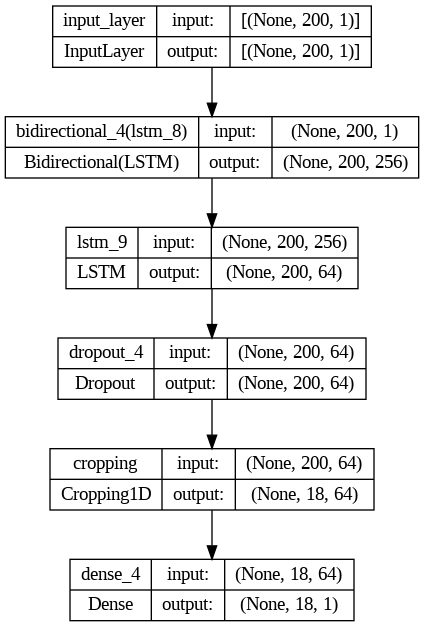

In [ ]:
model = build_bidirectional_LSTM(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Define the callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=training_hyperparameters['ES_patience'], restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=training_hyperparameters['R_LR_O_P_patience'], factor=training_hyperparameters['R_LR_O_P_factor'], mode='min', min_lr=training_hyperparameters['R_LR_O_P_min_lr'])

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = training_hyperparameters['batch_size'],
    epochs = training_hyperparameters['num_epochs'],
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, lr_scheduler],
).history

Epoch 1/100
127/127 [==============================] - 16s 94ms/step - loss: 0.0673 - val_loss: 0.0492 - lr: 0.0010
Epoch 2/100
127/127 [==============================] - 11s 87ms/step - loss: 0.0462 - val_loss: 0.0430 - lr: 0.0010
Epoch 3/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0427 - val_loss: 0.0403 - lr: 0.0010
Epoch 4/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0413 - val_loss: 0.0399 - lr: 0.0010
Epoch 5/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0408 - val_loss: 0.0381 - lr: 0.0010
Epoch 6/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0400 - val_loss: 0.0381 - lr: 0.0010
Epoch 7/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0374 - val_loss: 0.0356 - lr: 0.0010
Epoch 8/100
127/127 [==============================] - 11s 89ms/step - loss: 0.0364 - val_loss: 0.0534 - lr: 0.0010
Epoch 9/100
127/127 [==============================] - 11s 89ms/step - l

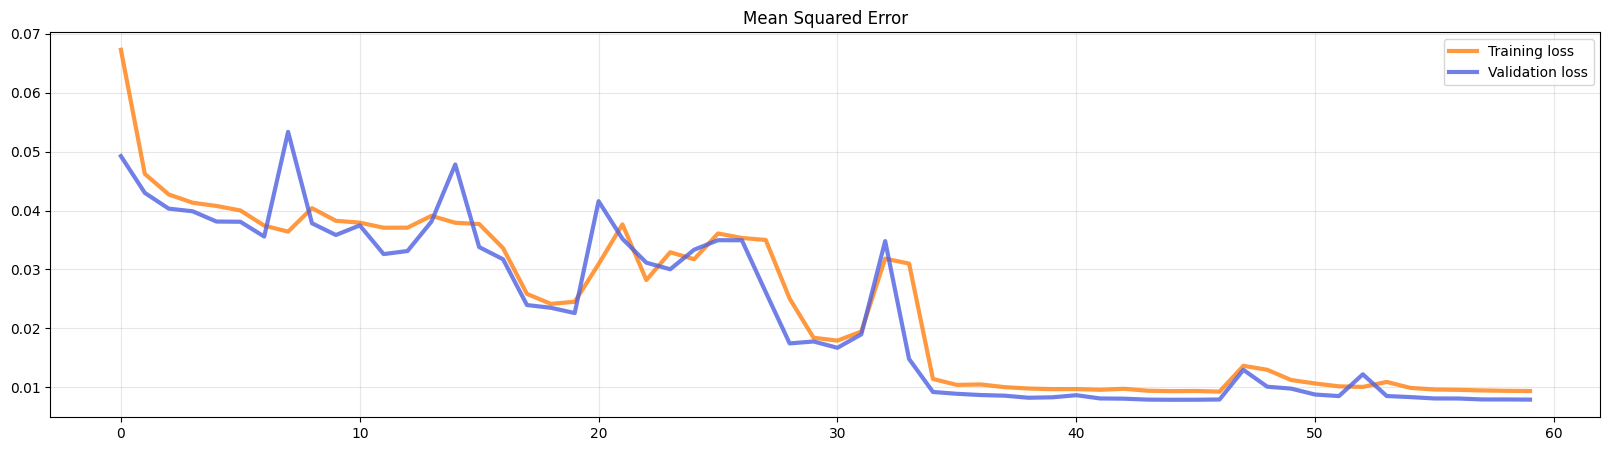

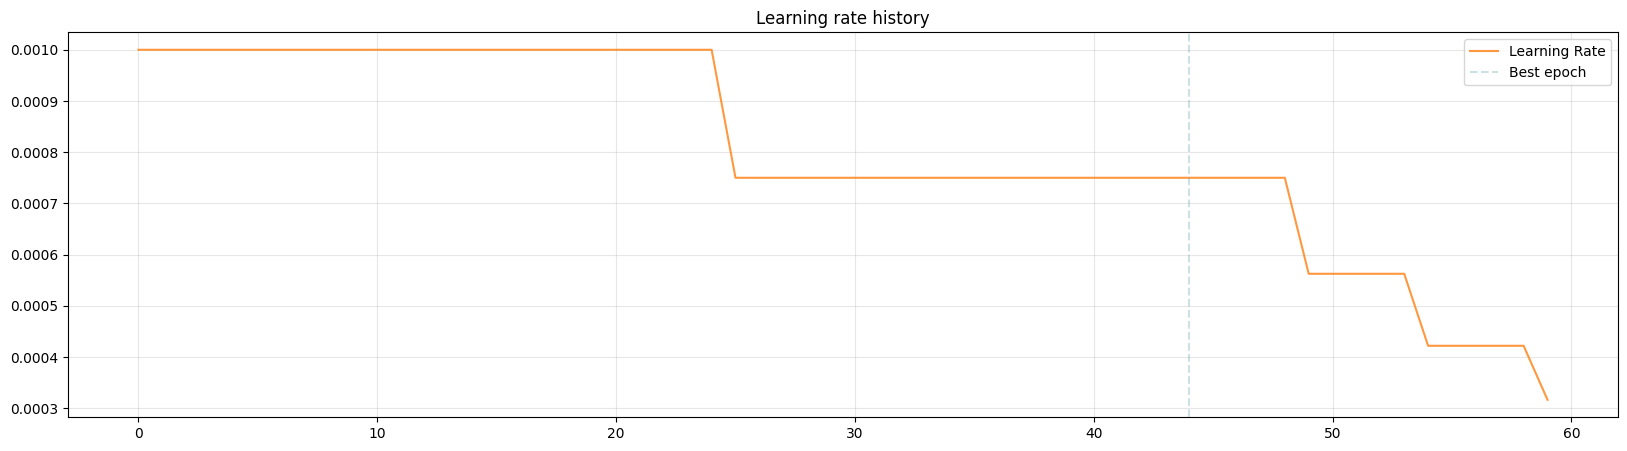

In [ ]:
plot_training(history)

In [ ]:
test_model(X_test, y_test, model_to_test=model)

Predictions shape: (20197, 18, 1)
Mean Squared Error: 0.007380941417068243
Mean Absolute Error: 0.04729531705379486


In [ ]:
end_experiment(experiment)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/albertosandri/anndl-ts-forecasting/56d4eb0dba234fd386442c5efef8efd4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [780]          : (0.00792290735989809, 0.1689966470003128)
COMET INFO:     epoch_duration [60]       : (10.907101546999911, 18.744668776999788)
COMET INFO:     loss [60]                 : (0.009244497865438461, 0.06729630380868912)
COMET INFO:     lr [60]                   : (0.0003164062509313226, 0.0010000000474974513)
COMET INFO:     val_loss [60]             : (0.007858454249799252, 0.05335550382733345)
COMET INFO:     validate_

In [ ]:
model.save(model_name)

In [ ]:
del model

In [ ]:
model = tfk.models.load_model(model_name)

In [ ]:
def inspect_prediction(X, y, pred, telescope):

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        plt.plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        plt.set_title(col)
        plt.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_prediction(X_test[0,:], y_test, predictions, 1, 18)

TypeError: ignored

### Embedding model

In [ ]:
model_name = 'embed'
experiment = create_experiment(model_name)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/gdrive/MyDrive/[2023-2024] AN2DL/Homework 2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/albertosandri/anndl-ts-forecasting/66b0154c82ad41e38ea9ae4399cb0f99



In [ ]:
training_hyperparameters = {
  'batch_size'        : 1024,
  'num_epochs'        : 200,
  'validation_split'  : 0.2,
  'test_split'        : 0.2,
  'ES_patience'       : 15,
  'R_LR_O_P_patience' : 5,
  'R_LR_O_P_factor'   : 0.75,
  'R_LR_O_P_min_lr'   : 1e-6,
  'window'            : 100,
  'stride'            : 25,
  'telescope'         : 18,
}
experiment.log_parameters(training_hyperparameters)

In [ ]:
network_hyperparameters = {
  'hidden_layer1'       : 'Bi-lstm',
  'hidden_layer1_units' : 128,
  'droput1'              : 0.2,
  #'hidden_layer1_activ' : 'relu',
  'hidden_layer2'       : 'bi-lstm',
  'hidden_layer2_units' : 64,
  'droput2'              : 0.2,
  'cropping'            : False,
  'dense_layer_units'   : 18,
  #'hidden_layer2_activ' : 'relu',
  #'conv1d_kernel_size'  : 3,
  #'conv1d_stride'       : 1,
}
experiment.log_parameters(network_hyperparameters)

In [ ]:
# Compute the indexes of the series longer than the window
valid_idxs = (valid_periods[:,1] - valid_periods[:,0]) > training_hyperparameters['window']

In [ ]:
# Split the series in train/val/test
train_samples = training_data[valid_idxs]
valid_periods_samples = valid_periods[valid_idxs]
categories_samples = categories[valid_idxs]

# Defining the number of samples in the test set and in the validation set
validation_size = training_hyperparameters['validation_split']
test_size = training_hyperparameters['test_split']

#train_samples = train_samples.reshape(train_samples.shape[0], train_samples.shape[1], 1)

# Split data into train_val and test sets
X_train_val, X_test, valid_periods_train_val, valid_periods_test, categories_train_val, categories_test = train_test_split(train_samples, valid_periods_samples, categories_samples, random_state=seed, test_size=test_size)

# Further split train_val into train and validation sets
X_train, X_val, valid_periods_train, valid_periods_val, categories_train, categories_val = train_test_split(X_train_val, valid_periods_train_val, categories_train_val, random_state=seed, test_size=validation_size)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (20853, 2776)
X_val shape: (5214, 2776)
X_test shape: (6517, 2776)


In [ ]:
# Create the datasets
X_train, y_train, categories_ohe_train = create_dataset_with_category_encoding(X_train, valid_periods_train, categories_train, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])
X_val, y_val, categories_ohe_val = create_dataset_with_category_encoding(X_val, valid_periods_val, categories_val, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])
X_test, y_test, categories_ohe_test = create_dataset_with_category_encoding(X_test, valid_periods_test, categories_test, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Creating Dataset: 100%|██████████| 6517/6517 [00:00<00:00, 45521.17it/s]


X_train shape: (111509, 100), y_train shape: (111509, 18)
X_val shape: (27504, 100), y_val shape: (27504, 18)
X_test shape: (35011, 100), y_test shape: (35011, 18)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
category_shape = categories_ohe_train.shape[1:]

input_shape, output_shape, category_shape

((1, 100, 1), (18, 1), (6,))

In [ ]:
# embed 4
def build_embedding_net(input_shape, output_shape, category_shape):
    # Define input shapes for time series data and one-hot encoded categories
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    input_category = tfkl.Input(shape=category_shape)

    # Bidirectional LSTM layers
    x = tfkl.Bidirectional(tfkl.LSTM(64))(input_layer)
    #x = tfkl.Dropout(0.3)(x)
    #x = tfkl.Bidirectional(tfkl.LSTM(64))(x)
    x = tfkl.Dropout(0.2)(x)

    #x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    #x = tfkl.Dropout(0.3)(x)
    #x = tfkl.Bidirectional(tfkl.LSTM(64))(x)
    #x = tfkl.Dropout(0.2)(x)
    #x = tfkl.Dense(64)(x)
    #x = tfkl.BatchNormalization()(x)
    #x = tfkl.ReLU()(x)
    #x = tfkl.Dropout(0.2)(x)
    # Dense layer for one-hot encoded categories
    #dense_category = tfkl.Dense(32, activation='relu')(input_category)

    dense_category = tfkl.Dense(32, activation='relu')(input_category)

    # Concatenate LSTM output and dense layer output
    concatenated = tfkl.Concatenate()([x, dense_category])

    output_layer = tfkl.Dense(output_shape[0])(concatenated)

    # Define the model with multiple inputs
    model = tfk.Model(inputs=[input_layer, input_category], outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 1, 100, 1)]          0         []                            
                                                                                                  
 conv_lstm1d_2 (ConvLSTM1D)  (None, 98, 64)               50176     ['input_layer[0][0]']         
                                                                                                  
 flatten_1 (Flatten)         (None, 6272)                 0         ['conv_lstm1d_2[0][0]']       
                                                                                                  
 dropout_2 (Dropout)         (None, 6272)                 0         ['flatten_1[0][0]']           
                                                                                              

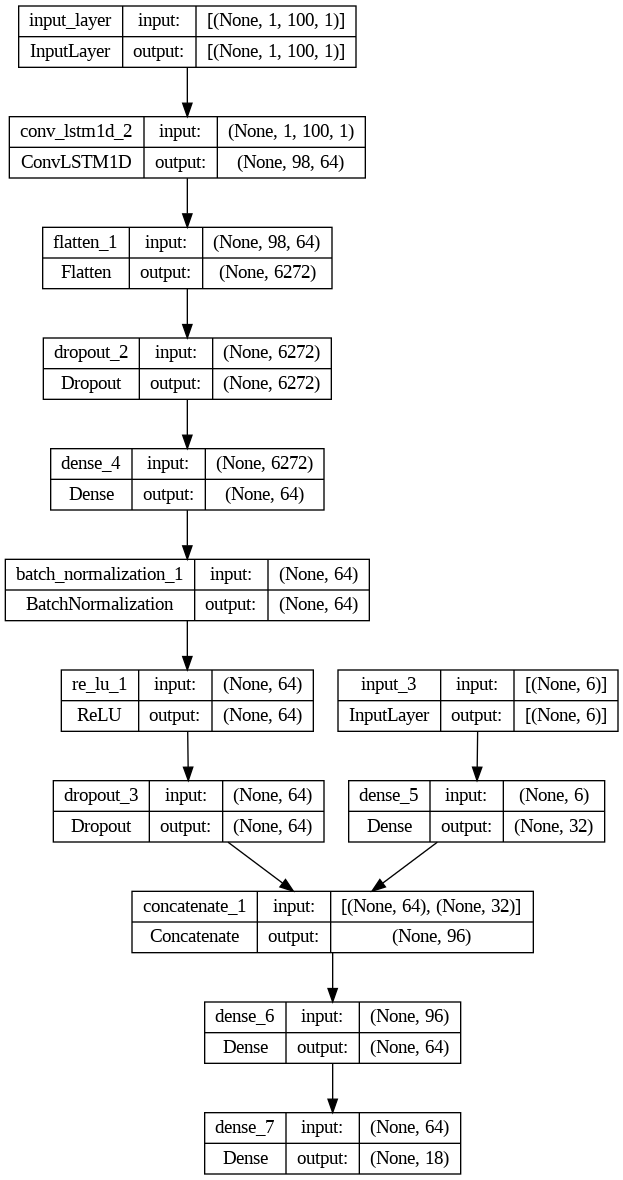

In [ ]:
model = build_embedding_net(input_shape, output_shape, category_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Define the callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=training_hyperparameters['ES_patience'], restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=training_hyperparameters['R_LR_O_P_patience'], factor=training_hyperparameters['R_LR_O_P_factor'], mode='min', min_lr=training_hyperparameters['R_LR_O_P_min_lr'])

# Train the model
history = model.fit(
    x = [X_train, categories_ohe_train],
    y = y_train,
    batch_size = training_hyperparameters['batch_size'],
    epochs = training_hyperparameters['num_epochs'],
    validation_data = ([X_val, categories_ohe_val], y_val),
    callbacks = [early_stopping, lr_scheduler],
).history

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/200
109/109 [==============================] - 16s 82ms/step - loss: 0.0532 - val_loss: 0.1018 - lr: 0.0010
Epoch 2/200
109/109 [==============================] - 5s 47ms/step - loss: 0.0138 - val_loss: 0.0676 - lr: 0.0010
Epoch 3/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0124 - val_loss: 0.0541 - lr: 0.0010
Epoch 4/200
109/109 [==============================] - 5s 46ms/step - loss: 0.0118 - val_loss: 0.0397 - lr: 0.0010
Epoch 5/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0115 - val_loss: 0.0269 - lr: 0.0010
Epoch 6/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0112 - val_loss: 0.0154 - lr: 0.0010
Epoch 7/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0109 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0108 - val_loss: 0.0099 - lr: 0.0010
Epoch 9/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0

In [ ]:
plot_training(history)

In [ ]:
model.save(model_name)

In [ ]:
test_model([X_test, categories_ohe_test], y_test, model_to_test=model)

Predictions shape: (35011, 18)
Mean Squared Error: 0.008701499551534653
Mean Absolute Error: 0.06277498602867126


In [ ]:
test_model([X_test, categories_ohe_test], y_test, model_to_test=model, telescope=9)

Predictions shape: (35011, 9)
Mean Squared Error: 0.006051966920495033
Mean Absolute Error: 0.05134984478354454


In [ ]:
end_experiment(experiment)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/albertosandri/anndl-ts-forecasting/c2d49772f63e4e30a851d50a4ac16372
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [4775]          : (0.006609419360756874, 0.3095996081829071)
COMET INFO:     epoch_duration [108]       : (8.490385357999912, 14.93205556599969)
COMET INFO:     loss [108]                 : (0.008217496797442436, 0.02267281897366047)
COMET INFO:     lr [108]                   : (3.167635077261366e-05, 0.0010000000474974513)
COMET INFO:     val_loss [108]             : (0.008674364537000656, 0.014416350983083248)
COMET INFO:     vali

In [ ]:
del model